# Dataset: Employee Churn

**Challenge 2**: Next up, Pear Inc needs a crystal ball to foresee who will staty with them. Develop a model that predicts employee churn, complete with churn probabilities to help Gabriele take timely action. Remember, Gabriele's no fan of black-box machines, and Fabio's looking for proof that your model's magic works.

## Library import

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import my_functions

from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

## Load dataset

In [2]:
data_raw = pd.read_csv("../datasets/employee-churn/churn.csv")
data = my_functions.data_preprocessing(data_raw)

# Final touches to the dataset
data.drop(columns='target_label', inplace=True)
data.drop(columns='enrollee_id', inplace=True)

data = data.dropna()
data = pd.get_dummies(data)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17567 entries, 0 to 19157
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   city                                  17567 non-null  float64
 1   city_development_index                17567 non-null  float64
 2   relevent_experience                   17567 non-null  bool   
 3   education_level                       17567 non-null  float64
 4   experience                            17567 non-null  float64
 5   company_size                          17567 non-null  float64
 6   last_new_job                          17567 non-null  float64
 7   training_hours                        17567 non-null  int64  
 8   target                                17567 non-null  float64
 9   gender_Female                         17567 non-null  bool   
 10  gender_Male                           17567 non-null  bool   
 11  gender_Not given    

## Split data into training and test datasset

The dataset is divided into two: the first part (80%) will be used to train the various models, while the remaining 20% will be the test dataset on which the various models will finally be verified.

In [3]:
y_data = data['target']
x_data = data.drop(columns='target')

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [5]:
print(f"Percentage of people quitting Pear Inc [train dataset]: {round(100*sum(y_train)/len(y_train),2)}%")
print(f"Percentage of people quitting Pear Inc [test dataset]: {round(100*sum(y_test)/len(y_test),2)}%")

Percentage of people quitting Pear Inc [train dataset]: 23.9%
Percentage of people quitting Pear Inc [test dataset]: 24.56%


## First model: decision tree

Decision trees are a machine learning algorithm based on a flow diagram. At each node, a certain condition is checked on the input variables and based on this discrimination the data is divided into two subnodes. The process always starts from a root node and moves downwards, gradually checking various conditions. For example, a condition could be a variable major or minor of a certain threshold value. The intermediate nodes are called decision nodes, while the final ones (i.e. those beyond which no further division occurs) are called leaves.

In [6]:
clf_tree = tree.DecisionTreeClassifier(max_depth=6).fit(x_train, y_train)

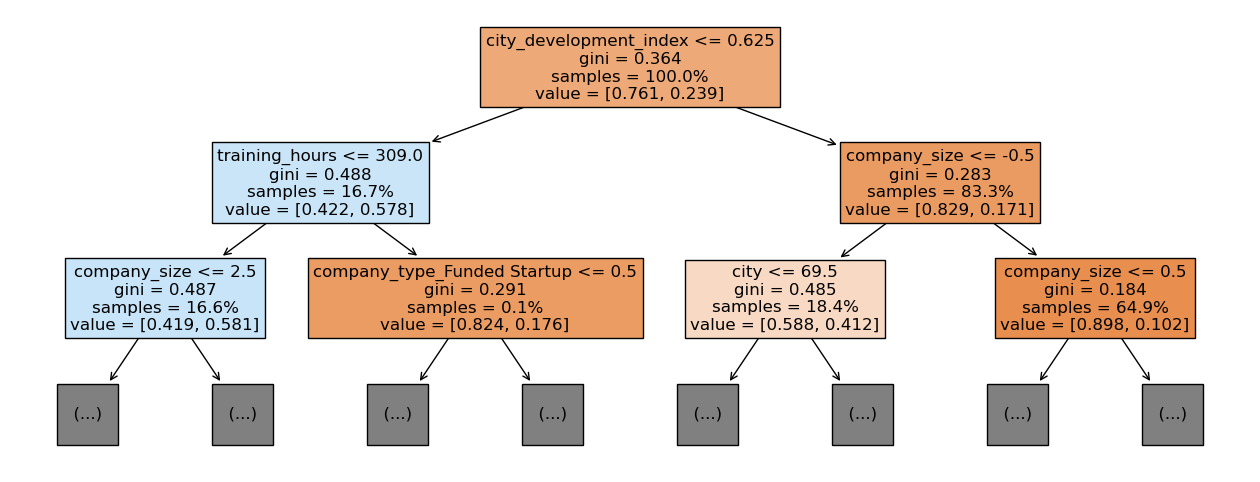

In [7]:
fig, axs = plt.subplots(1,1, figsize=(16,6))
tree.plot_tree(clf_tree, max_depth=2, feature_names=x_train.columns, proportion=True, fontsize=12, filled=True)
plt.show()

### Model testing

In [8]:
score_tree = clf_tree.score(x_test, y_test)
print(f"Mean accuracy on the test data: {score_tree}")

Mean accuracy on the test data: 0.8019351166761526


## Second model: Random Forest

A Random Forest is an Ensemble Learning algorithm that works by creating a multitude of decision trees. The final output of the model will be the average of the outputs of all the decision trees that make up the forest. Each single decision tree is created taking into account a subset of data and a subset of variables.

In [9]:
clf_forest = RandomForestClassifier(n_estimators=8, max_depth=6).fit(x_train, y_train)

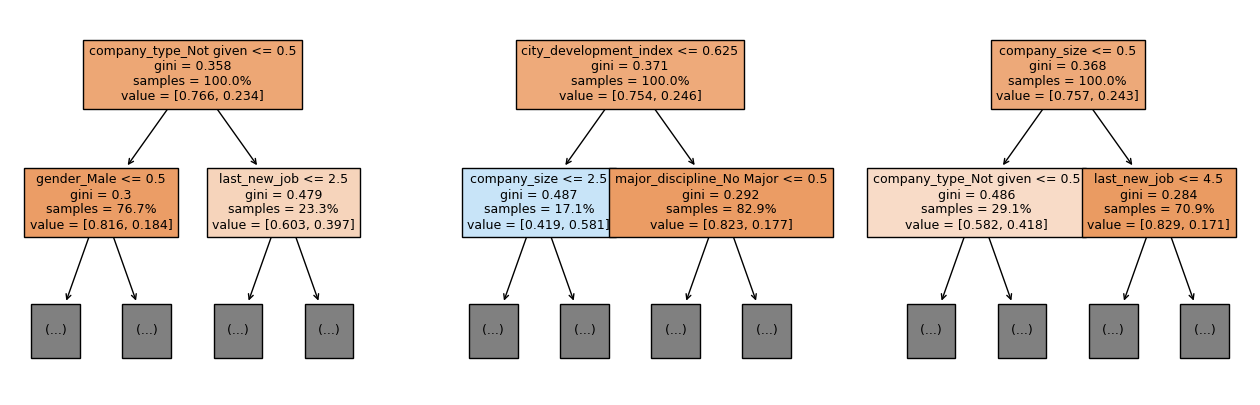

In [10]:
fig, axs = plt.subplots(1,3, figsize=(16,5))
for index in range(0, 3):
    tree.plot_tree(
        clf_forest.estimators_[index],
        max_depth=1,
        feature_names = x_data.columns, 
        fontsize=9,
        proportion=True, 
        filled = True,
        ax = axs[index])
plt.show()

### Model testing

In [11]:
score_forest = clf_forest.score(x_test, y_test)
print(f"Mean accuracy on the test data: {score_forest}")

Mean accuracy on the test data: 0.7694934547524189


## Third model: K-nearest neighbors

A k-nearest neighbors algorithm is a machine learning method in which the input is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). The training data are vectors in a multidimensional feature space and the commonly used distance metric for continuous variables is Euclidean distance.

In [12]:
clf_knn = KNeighborsClassifier(n_neighbors=10).fit(x_train, y_train)

### Model testing

In [13]:
score_knn = clf_knn.score(x_test, y_test)
print(f"Mean accuracy on the test data: {score_knn}")

Mean accuracy on the test data: 0.7700626067159931


## Final model: Voting Classifier

The above examples show that there is no perfect algorithm, and that each type of classifier has its strengths and weaknesses. To take advantage of each of them, you can use a Voting Classifier, which is a set of different models that returns a democratic decision on which is the best output. In our case I will use the three previously defined models.

In [14]:
clf_voting = VotingClassifier(
    estimators=[('tree', clf_tree), ('forest', clf_forest), ('knn', clf_knn)],
    voting='soft').fit(x_train, y_train)

In [15]:
final_score = clf_voting.score(x_test, y_test)
print(f"Mean accuracy on the test data: {final_score}")

Mean accuracy on the test data: 0.7868525896414342


### Grid search for hyperparameter tuning

One method you can use to find the best parameters for a model is the `GridSearchCV`. First we define a dictionary with the parameters to be tuned and the values of the latter that we want to use. The algorithm tries all the possible combinations of parameters provided by the dictionary using a cross-validation splitting strategy and then return the model fitted with the best ones parameters.

In this case I tried to tune the voting classifier by discriminating between the voting method and the weight to give to each model.

In [23]:
clf_voting_grid = VotingClassifier(
    estimators=[('tree', clf_tree), ('forest', clf_forest), ('knn', clf_knn)],
    )

params = {
    'voting':['hard', 'soft'],
    'weights':[(1,1,1), (2,1,1), (1,2,1), (1,1,2), (2,2,1), (1,2,2), (2,1,2)]
}

clf_grid = GridSearchCV(clf_voting_grid, params).fit(x_train, y_train)

clf_grid.best_params_

{'voting': 'soft', 'weights': (2, 1, 1)}

In [24]:
clf_grid.score(x_test, y_test)

0.7899829254410927

## Save the model

In [32]:
pickle.dump(clf_grid, open("model.pkl", "wb"))
model = pickle.load(open('model.pkl', 'rb'))
model.score(x_test, y_test)

0.7899829254410927

## Final considerations and further improvments